In [1]:
import numpy as np
import matplotlib.pyplot as plt

#### UCB1 agent from previous lectures

In [2]:
class UCB1Agent:
    def __init__(self, K, range=1):
        self.K = K
        self.range = range
        self.a_t = None
        self.average_rewards = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.t = 0
    
    def pull_arm(self):
        if self.t < self.K:
            self.a_t = self.t 
        else:
            ucbs = self.average_rewards + self.range*np.sqrt(2*np.log(self.t)/self.N_pulls)
            self.a_t = np.argmax(ucbs)
        return self.a_t
    
    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.average_rewards[self.a_t] += (r_t - self.average_rewards[self.a_t])/self.N_pulls[self.a_t]
        self.t += 1

# Contextual Bandits

#### Stationary bandits with $K$ arms
- #### There is a set of contexts $\mathcal{X}$
- #### The expected rewards $\mu(a|x)$ depend on the arm $a \in [K]$ and the context $x \in \mathcal{X}$
- #### At each time step $t \in [T]$ the environemnt selects a context $x_t \in \mathcal{X}$
- #### The agent observes $x_t$ and selects $a_t$
- #### The agent obtains (and observes) $r_t$ with $\mathbb{E}[r_t] = \mu(a_t|x_t)$

#### Assumption: The sequence of contexts $x_1, x_2 \dots, x_T$ is chosen by an oblious adversary

#### Regret:
#### $$ \mathbb{E}\left[ \sum_{t \in [T]} \mu(\pi^\star(x_t)|x_t) - \sum_{t \in [T]} \mu(a_t|x_t) \right]$$
#### with $ \pi^\star(x) = \argmax_{a \in [K]} \mu(a|x)$

#### We will consider three scenarios:
- #### Small number of contexts
- #### Lipschitz contextual bandits
- #### Linear contextual bandits

## Small number of contexts

#### Idea: if $N \coloneqq |\mathcal{X}|$ is small, we can run a different regret minimizer for each context

In [3]:
mu = np.array([[0.4, 0.7, 0.5, 0.8],
               [0.8, 0.3, 0.6, 0.7],
               [0.3, 0.8, 0.7, 0.5]])
X = np.arange(mu.shape[0])
K = mu.shape[1]
print(f'Number of contexts: {len(X)}')
print(f'Number of arms: {K}')

Number of contexts: 3
Number of arms: 4


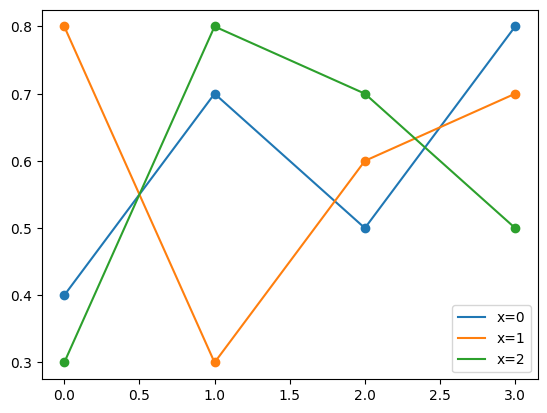

In [4]:
for x in X:
    plt.plot(mu[x,:], label=f'x={x}')
    plt.scatter(np.arange(K), mu[x,:])
plt.legend()
plt.show()

### Environment

In [5]:
class FewContextsEnv():
    def __init__(self, mu, xs):
        self.xs = xs
        T = len(xs)
        self.rewards = np.zeros((T, mu.shape[1]))
        # for x in xs:
        #     mask = xs == x
        #     self.rewards[mask,:] = np.random.binomial(n=1,p=mu[x,:], size=(np.sum(mask),mu.shape[1]))
        for t, x in enumerate(xs):
            self.rewards[t,:] = np.random.binomial(n=1,p=mu[x,:])
        self.t = 0
    
    def obs_context(self):
        return self.xs[self.t]
    
    def round(self, a_t):
        r_t = self.rewards[self.t, a_t]
        self.t +=1
        return r_t

#### For simplicty, we will consider contexts drawn from a fixed distribution.
#### The algorithms that we will see work for any sequence of contexts.

In [6]:
np.random.seed(20)
T = 6000
xs = np.random.choice(mu.shape[0], size=T)
env = FewContextsEnv(mu, xs)
print(env.t)
x_t = env.obs_context()
r_t = env.round(0)
print(x_t, r_t, env.t)

0
2 0.0 1


In [7]:
for x in range(mu.shape[0]):
    mask = xs == x
    rewards_x = env.rewards[mask,:]
    print(f'x:{x}, true avg:{mu[x,:]}, emp avg:{np.average(rewards_x,axis=0)}')

x:0, true avg:[0.4 0.7 0.5 0.8], emp avg:[0.40029615 0.70927937 0.48272458 0.80503455]
x:1, true avg:[0.8 0.3 0.6 0.7], emp avg:[0.79013588 0.29139406 0.61550075 0.71464519]
x:2, true avg:[0.3 0.8 0.7 0.5], emp avg:[0.31655762 0.79265224 0.68595873 0.50427781]


### Baseline

In [8]:
mu = np.array([[0.4, 0.7, 0.5, 0.8],
               [0.8, 0.3, 0.6, 0.7],
               [0.3, 0.8, 0.7, 0.5]])
np.random.seed(20)
T = 3000
xs = np.random.choice(mu.shape[0], size=T)

pi = np.argmax(mu, axis=1)
optimal_rewards = np.max(mu, axis=1) 
expected_clairvoyant_rewards = optimal_rewards[xs]

### Agent

In [9]:
class FewContextsUCBAgent():
    def __init__(self, K, N, scale=1):
        self.K = K
        self.agents = [UCB1Agent(K, range=1) for _ in range(N)]
        self.x_t = None
        self.a_t = None
        self.t = 0
    
    def pull_arm(self, x_t):
        agent_t = self.agents[x_t]
        self.a_t = agent_t.pull_arm()
        self.x_t = x_t
        return self.a_t
    
    def update(self, r_t):
        agent_t = self.agents[self.x_t]
        agent_t.update(r_t)
        self.t += 1

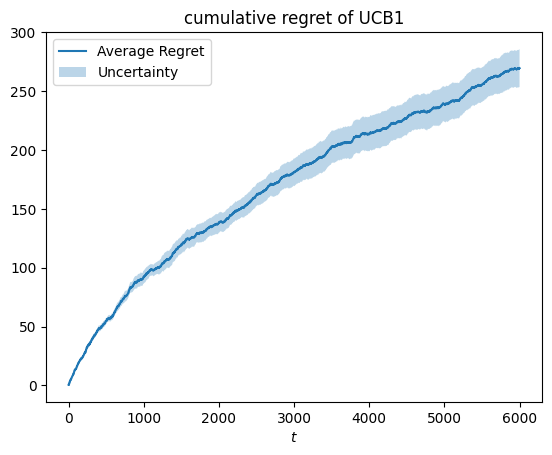

In [10]:
mu = np.array([[0.4, 0.7, 0.5, 0.8],
               [0.8, 0.3, 0.6, 0.7],
               [0.3, 0.8, 0.7, 0.5]])
np.random.seed(20)
T = 6000
xs = np.random.choice(mu.shape[0], size=T)

pi = np.argmax(mu, axis=1)
optimal_rewards = np.max(mu, axis=1) 
expected_clairvoyant_rewards = optimal_rewards[xs]

n_trials = 10

regret_per_trial = []

for seed in range(n_trials):
    np.random.seed(seed)
    env = FewContextsEnv(mu, xs)
    agent = FewContextsUCBAgent(mu.shape[1], mu.shape[0])

    agent_rewards = np.array([])

    for t in range(T):
        x_t = env.obs_context()
        a_t = agent.pull_arm(x_t)
        r_t = env.round(a_t)
        agent.update(r_t)

        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of UCB1')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()

#### Simpler instance

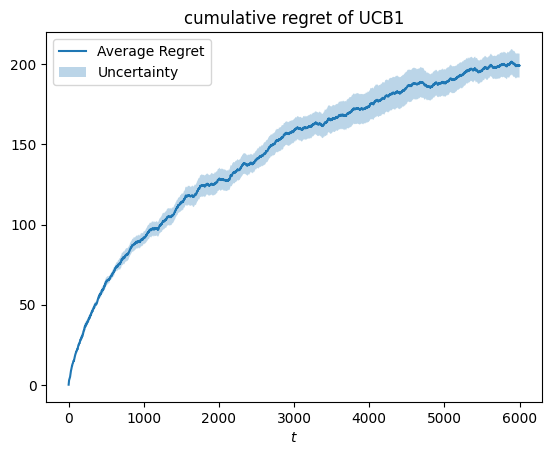

In [11]:
mu = np.array([[0.4, 0.6, 0.5, 0.85],
               [0.85, 0.3, 0.6, 0.55]])
np.random.seed(20)
T = 6000
xs = np.random.choice(mu.shape[0], size=T)

pi = np.argmax(mu, axis=1)
optimal_rewards = np.max(mu, axis=1) 
expected_clairvoyant_rewards = optimal_rewards[xs]

n_trials = 10

regret_per_trial = []

for seed in range(n_trials):
    np.random.seed(seed)
    env = FewContextsEnv(mu, xs)
    agent = FewContextsUCBAgent(mu.shape[1], mu.shape[0])

    agent_rewards = np.array([])

    for t in range(T):
        x_t = env.obs_context()
        a_t = agent.pull_arm(x_t)
        r_t = env.round(a_t)
        agent.update(r_t)

        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of UCB1')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()

## Structured Contextual Bandits

#### What if $N= |\mathcal{X}|$ is big, possibly infinte?
#### We need some underlying structure to tackle the problem

## Lipschitz Contextual Bandits
- #### Context space $\mathcal{X} = [0,1]$
- #### (Expected) Utilities are Lipschitz in the context: $|\mu(a|x) - \mu(a,x')| \le L |x - x'| \; \forall a \in [K], x,x' \in \mathcal{X}$

In [12]:
class LipschitzContEnv():
    def __init__(self, mu, xs):
        # mu is a tuple of functions mu_a : x -> [0,1], one for each arm, working also with arrays
        self.xs = xs
        T = len(xs)
        self.rewards = np.zeros((T, len(mu)))
        for k, f in enumerate(mu):
            probabilities = f(xs)
            self.rewards[:, k] = np.random.binomial(n=1,p=probabilities, size=T)
        self.t = 0
    
    def obs_context(self):
        return self.xs[self.t]
    
    def round(self, a_t):
        r_t = self.rewards[self.t, a_t]
        self.t +=1
        return r_t

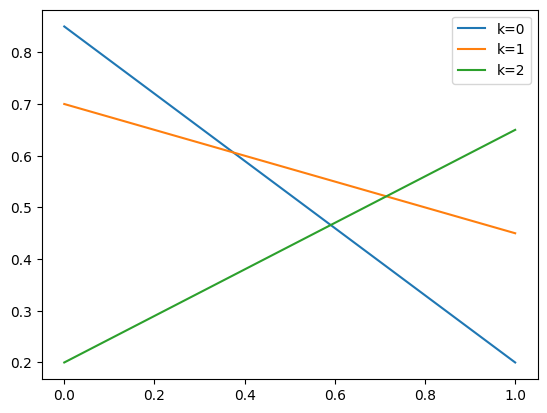

In [13]:
mu = (lambda x: 0.85 -0.65*x, lambda x: 0.7 -0.25*x, lambda x: 0.2 +0.45*x)
xs = np.linspace(0,1)
for k,f in enumerate(mu):
    plt.plot(xs, f(xs), label=f'k={k}')
plt.legend()
plt.show()

In [14]:

np.random.seed(20)
T = 3000
xs = np.random.random_sample(size=T)
env = LipschitzContEnv(mu, xs)
print(env.t)
x_t = env.obs_context()
r_t = env.round(0)
print(x_t, r_t, env.t)

0
0.5881308010772742 0.0 1


### Baseline

In [15]:
mu = (lambda x: 0.85 -0.65*x, lambda x: 0.7 -0.25*x, lambda x: 0.2 +0.45*x)
T = 3000
xs = np.random.random_sample(size=T)

clairvoyant_actions = np.zeros(T)
expected_clairvoyant_rewards = np.zeros(T)
for t, x in enumerate(xs):
    expected_rewards = [mu[k](x) for k in range(len(mu))]
    clairvoyant_actions[t] = np.argmax(expected_rewards)
    expected_clairvoyant_rewards[t] = np.max(expected_rewards)
expected_clairvoyant_rewards = np.array(expected_clairvoyant_rewards)
expected_clairvoyant_rewards.shape

(3000,)

In [16]:
def compute_lip_clairvoyant_reward(mu, xs):
    T = len(xs)
    clairvoyant_actions = np.zeros(T)
    expected_clairvoyant_rewards = np.zeros(T)
    for t, x in enumerate(xs):
        expected_rewards = [mu[k](x) for k in range(len(mu))]
        clairvoyant_actions[t] = np.argmax(expected_rewards)
        expected_clairvoyant_rewards[t] = np.max(expected_rewards)
    return np.array(expected_clairvoyant_rewards)

### Agent
#### Idea: 
- #### Discretize the set of contexts into a grid $\mathcal{X}_\epsilon$ of size $\epsilon$.
- #### Map $x_t$ to the nearest context in the grid.
- #### Instantiate a regret minimizer for each context in $\mathcal{X}_\epsilon$

In [17]:
class LipshitzContUCBAgent():
    def __init__(self, K, epsilon, scale=1):
        self.K = K
        self.range = scale
        self.X_ep = np.linspace(start=0,stop=1,num=int(1/epsilon)+2)
        self.agents = [UCB1Agent(K, range=1) for _ in range(len(self.X_ep))]
        self.discretixed_x_t = None
        self.a_t = None
        self.t = 0
    
    def pull_arm(self, x_t):
        discretixed_x = np.argmin(np.abs(self.X_ep - x_t))
        agent_t = self.agents[discretixed_x]
        self.a_t = agent_t.pull_arm()
        self.discretixed_x_t = discretixed_x
        return self.a_t
    
    def update(self, r_t):
        agent_t = self.agents[self.discretixed_x_t]
        agent_t.update(r_t)
        self.t += 1

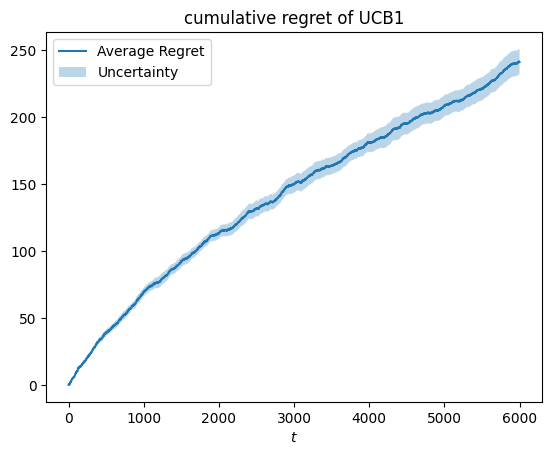

In [26]:
mu = (lambda x: 0.85 -0.65*x, lambda x: 0.7 -0.25*x, lambda x: 0.2 +0.45*x)
T = 6000
np.random.seed(20)
xs = np.random.random_sample(size=T)
 
expected_clairvoyant_rewards = compute_lip_clairvoyant_reward(mu, xs)

# we consider L = 1 (upper bound)
epsilon = np.cbrt(K*np.log(T)/T)

n_trials = 20

regret_per_trial = []

for seed in range(n_trials):
    np.random.seed(seed)
    env = LipschitzContEnv(mu, xs)
    agent = LipshitzContUCBAgent(len(mu), epsilon)

    agent_rewards = np.array([])

    for t in range(T):
        x_t = env.obs_context()
        a_t = agent.pull_arm(x_t)
        r_t = env.round(a_t)
        agent.update(r_t)

        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of UCB1')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()

In [29]:
print(len(agent.X_ep))

8


## Contextual Linear Bandits

- #### A context $x$ specifies a "feature map"
- #### $x = (x_{a_1}, x_{a_2}, \dots, x_{a,k})$ with $x_{a_i} \in \mathbb{R}^d$ 
- #### The expected reward of arm $a$, context $x$, is $\mu(a|x) = \langle \theta^\star,x_a \rangle$
- #### $\theta^\star \in \mathbb{R}^d$ is an unknown vector

#### Interaction:
- #### At each time step $t \in [T]$ the environemnt selects a context $x_t \in \mathcal{X}$
- #### The agent observes $x_t$ and pulls $a_t$
- #### The agent collects (and observes) $r_t = \langle \theta^\star,x_a \rangle + \eta_t$
- #### $\eta_t$ is a subguassion

In [19]:
class LinearContEnv():
    def __init__(self, theta_star, xs, K, sigma=0.3):
        # xs is a list of (K,d) matrices or a (T,K,d) array
        self.xs = xs
        self.theta_star = theta_star
        T = len(xs)
        self.rewards = np.zeros((T, K))
        for t, X in enumerate(xs):
            mu = X @ theta_star
            self.rewards[t, :] = mu + np.random.normal(loc=0,scale=sigma,size=len(mu)) 
        self.t = 0
    
    def obs_context(self):
        return self.xs[self.t]
    
    def round(self, a_t):
        r_t = self.rewards[self.t, a_t]
        self.t +=1
        return r_t

In [20]:
theta_star = np.array([0.3,0.7])
K = 3
np.random.seed(20)
T = 1000
xs = np.random.random_sample(size=(T,K,len(theta_star)))
env = LinearContEnv(theta_star, xs, K)
print(f'inital time:{env.t}')
x_t = env.obs_context()
r_t = env.round(0)
print('x_0:',x_t)
print(f'r_0:{r_t}, next time:{env.t}')

inital time:0
x_0: [[0.5881308  0.89771373]
 [0.89153073 0.81583748]
 [0.03588959 0.69175758]]
r_0:0.4729891156390584, next time:1


### Baseline

In [21]:
def compute_linear_clairvoyant_reward(xs, theta_star):
    rewards = []
    for t, X in enumerate(xs):
        mu = X @ theta_star
        rewards.append(np.max(mu))
    return rewards

### Agent
- #### Compute emirical estimator $\hat \theta_t$
- #### Compute confidence interval $C_t$ around $\hat \theta_t$
- #### Construct $UCB_t(a) = \sup_{\theta \in C_t} \langle \theta, x_{t,a} \rangle $
- #### Pull $a_t = \argmax_{a \in [K]} UCB_t(a)$

#### Building $C_t$:
#### $$ \hat \theta = (X_{0:t}^T X_{0:t} + \lambda I)^{-1}X_{0:t}^Tr_{0:t}$$
#### With high probability:
#### $$ |\langle x_{t,a}, \theta - \theta^\star \rangle | \le \beta \sqrt{x_{t,a}^T A^{-1} x_{t,a} }$$
#### for appropriate $\beta$

#### Incremental updates from $A_1 = \lambda I_d$, $b_1 = \bold{0}$:
#### $$ \hat \theta_t = A_t^{-1} b_t$$
#### $$ UCB_t(a) = \langle \hat \theta_t, x_{t,a} \rangle + \beta \sqrt{x_{t,a}^T A^{-1} x_{t,a} }$$
#### $$ A_{t+1} = A_t + x_{t,a_t} x_{t,a_t}^T$$
#### $$ b_{t+1} = b_t + x_{t,a_t} r_t$$


In [22]:
class LinUCBAgent():
    def __init__(self, K, d, lmd, beta):
        self.K = K
        self.d = d
        self.A_t = np.identity(d) * lmd
        self.b_t = np.zeros(d)
        self.beta = beta
        self.a_t = None
        self.t = 0
    
    def pull_arm(self, x_t):
        A_inv = np.linalg.inv(self.A_t)
        theta_hat = A_inv@self.b_t
        theta_hat = np.reshape(theta_hat, self.d)
        # print(f'theta_hat shape:{theta_hat.shape}')
        ucbs = np.zeros(self.K)
        for k in range(self.K):
            x_t_a = np.reshape(x_t[k,:],shape=(len(x_t[k,:]),1))
            exploration = self.beta * np.sqrt(x_t_a.T @ A_inv @ x_t_a)
            if isinstance(exploration, np.ndarray):
                # print('exploration:',exploration)
                exploration = exploration[0,0]
            ucbs[k] = theta_hat@x_t[k,:] + exploration
        self.a_t = np.argmax(ucbs)
        return self.a_t
    
    def update(self, r_t):
        x_t_a = np.reshape(x_t[self.a_t,:],shape=(len(x_t[self.a_t,:]),1))
        self.A_t = self.A_t + x_t_a @ x_t_a.T
        self.b_t = self.b_t + x_t[self.a_t,:]*r_t
        self.t += 1

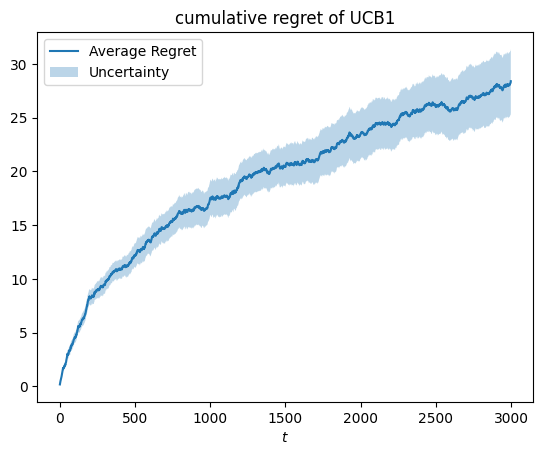

In [23]:
theta_star = np.array([0.3,0.7])
K = 3
np.random.seed(20)
T = 3000
# xs = np.random.random_sample(size=(T,K,len(theta_star)))
xs = np.array([np.array([[0.2,0.7], [0.5,0.5], [0.7, 0.3]]) for _ in range(T)])

expected_clairvoyant_rewards = compute_linear_clairvoyant_reward(xs, theta_star)

beta = np.sqrt(np.log(2*T*K*np.log(T))/2)

n_trials = 40

regret_per_trial = []

for seed in range(n_trials):
    np.random.seed(seed)
    env = LinearContEnv(theta_star, xs, K)
    agent = LinUCBAgent(K, len(theta_star), 0.01, beta)

    agent_rewards = np.array([])

    for t in range(T):
        x_t = env.obs_context()
        a_t = agent.pull_arm(x_t)
        r_t = env.round(a_t)
        agent.update(r_t)

        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of UCB1')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()

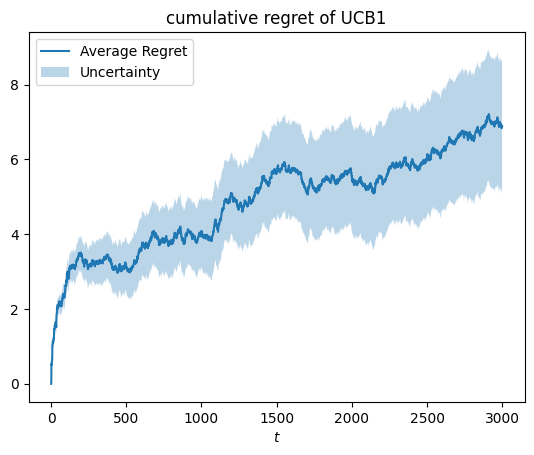

In [25]:
theta_star = np.array([0.3,0.7])
K = 3
np.random.seed(20)
T = 3000
xs = np.random.random_sample(size=(T,K,len(theta_star)))

expected_clairvoyant_rewards = compute_linear_clairvoyant_reward(xs, theta_star)

beta = np.sqrt(np.log(2*T*K*np.log(T))/2)

n_trials = 100

regret_per_trial = []

for seed in range(n_trials):
    np.random.seed(seed)
    env = LinearContEnv(theta_star, xs, K)
    agent = LinUCBAgent(K, len(theta_star), 0.01, beta)

    agent_rewards = np.array([])

    for t in range(T):
        x_t = env.obs_context()
        a_t = agent.pull_arm(x_t)
        r_t = env.round(a_t)
        agent.update(r_t)

        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of UCB1')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()